# PyTorch - Unsupervised Learning - 3
 >__Created__: June 2020, Tallahassee, USA 
 
## Introduction
We consider the task of __unsupervised__ clustering the the $28 \times 28 = 784$ gray scale images of handwritten digits in the [MNIST](http://yann.lecun.com/exdb/mnist) data set. We do this using an autoencoder, which implements the identity map $f: x \rightarrow x$, but with a crucial twist. The map $f$ is implemented in two steps: first the map $e: x \rightarrow z$ followed by the map $d: z \rightarrow x$, where the space $z \equiv (z_1, z_2) \in R^2$, often referred to as a __latent__ space, is of much dimensionality than the 784-D space of the images. We use the quadratic loss between the inputs to the __encoder__ function $z = e(x)$
and the outputs of the __decoder__ function $x = d(z)$. Recall that the quadratic loss leads to the result
\begin{align}
    f(x) & = \int y \, p(y \, | \, x) \, dy,
\end{align}
where $x$ are the inputs, here images, and $y$ are the targets. But,since $y = x$, $p(y \, | \, x) = \delta(y - x)$, which implies that a sufficiently flexible autoencoder $f(x)$ provides an *unbiased* estimate of its inputs, via its latent space.

The data contains $T = 60,000$ images for training and 10,000 images for testing. Following good practice, we split the training data into a set for training and another for validating the training. The test data are not used in the training.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl
import imageio as im

#  a function to load and save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# pytorch's automatic differentiation 
from torch.autograd import Variable

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 20
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)
# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load Images

If the files are do not exist, go to the datasets folder and run the notebook prepare_mnist_data.ipynb to create them.

In [3]:
train_x, train_y = jb.load('../datasets/mnist_train.pkl')
test_x,  test_y  = jb.load('../datasets/mnist_test.pkl')

In [4]:
def plotImages(x, n_rows=8, n_cols=8, f_size=(4, 4)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

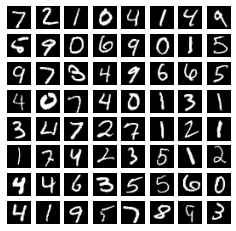

In [5]:
plotImages(test_x[:64])

### Prepare training and validation sets

In [6]:
train_fraction = 0.9   # fraction of data used for training
learning_rate  = 1.e-3

M = int(train_fraction*len(train_x))
train_x, val_x = train_x[:M], train_x[M:]
train_y, val_y = train_y[:M], train_y[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        54000
number of images for validation:       6000
number of images for testing:         10000


### Define autoencoder class
Here, for simplicity, we use the __Sequential__ class to define the structure of the model.

In [7]:
class autoencoder(nn.Module):
    
    def __init__(self, Nl=2):
        # initialize the base (that is, parent class)
        super(autoencoder, self).__init__()
        
        Nx = 28*28    # dim of input space
        self.y = None # to cache results of encoder
        
        self.encoder = nn.Sequential(
            nn.Linear(Nx, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64,  16), nn.ReLU(),
            nn.Linear(16,  Nl)) # dim of latent space
        
        self.decoder = nn.Sequential(
            nn.Linear(Nl,  16), nn.ReLU(),
            nn.Linear(16,  64), nn.ReLU(),
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, Nx))

    def z(self):
        return self.y.detach().numpy()
    
    def forward(self, x):
        y = x
        y = self.encoder(y)
        self.y = y; # cache result of encoder.
        y = self.decoder(y)
        return y

### Get next batch of images
Get a sample from the training set of size $n\_batch$

In [8]:
class Batch:
    def __init__(self, x, size):
        self.x     = x
        self.size  = size
        self.n     = len(self.x)
        
    def __del__(self):
        pass
    
    def next(self):
        # the numpy function choice(length, number)
        # selects at random "number" integers from the range [0, length-1]
        rows = rnd.choice(self.n, self.size)
        return self.x[rows]

### Instantiate an autoencoder and an optimizer

In [9]:
model = autoencoder()
avloss= nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=1e-5)

### Set up training sequence

In [10]:
def train(model, optimizer, avloss, batch):
    # set mode to training in case the model includes training specific 
    # operations such as dropout. (The method, train(), sets the boolean 
    # self.training to True)
    model.train()
    
    # Get a batch of images
    batch_x = batch.next()
        
    # Convert the numpy array batch_x to tensor types and
    # then to Variable types. The later is the expected type 
    # into models and the loss functions. (Note: a loss function, as used
    # in ML is really the average loss or the empirical risk function.)
    #
    # The type Variable is the magic that permits automatic 
    # differentiation with respect to its arguments. However, we do not
    # need derivatives with respect to the images, so we disable it.
    with torch.no_grad(): # no need to compute gradients wrt. x
        x = Variable(torch.from_numpy(batch_x))      

    # compute the output of the model for the batch of images x
    outputs = model(x)
    
    # compute a noisy approximation to the average loss
    loss    = avloss(outputs, x)
    
    # use automatic differentiation to compute a noisy approximation
    # of the local gradient. The noisy gradient increases the probability
    # that the optimizer will, by chance, exit from a local minimum. (In principle,
    # if we knew we were approaching a good approximation to the global minimum, it
    # would make sense to reduce the noise in the gradient by increasing the batch
    # size.)
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    
    # Finally, advance one step in the direction of steepest descent,
    # using the noisy local gradient. 
    optimizer.step()       # move one step
        
def validate(model, train_x, val_x):
    # make sure we set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x
        # compute accuracy using training sample
        x = Variable(torch.from_numpy(train_x))
        o = model(x)
        acc_t = avloss(o, x)
  
        # compute accuracy using validation sample
        x = Variable(torch.from_numpy(val_x))
        o = model(x)
        acc_v = avloss(o, x)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, avloss, 
               train_x, val_x,
               n_iterations, batch):
    xx   = []
    yy_t = []
    yy_v = []

    for ii in range(n_iterations):
        
        # do one step of minimization
        train(model, optimizer, avloss, batch)
        
        if   ii < 100:
            step = 10
        elif ii < 1000:
            step = 100
        else:
            step = 1000
            
        if ii % step == 0:
            acc_t, acc_v = validate(model, train_x, val_x) 
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

plot loss function vs. iteration

In [25]:
def plot(xx, yy_t, yy_v):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # adjust y limits
    axes = ax.axes
    axes.set_ylim((1.e-2, 2.e-1))
    axes.set_xlim((0, xx[-1]))
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')

    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('loss', fontsize=16)
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='-')
    plt.legend(loc='lower right')
    
    fig.tight_layout()
    plt.show()

### Now train!

In [15]:
n_iter   = 28000    # number of iterations
n_batch  =   128    # N = n_batch
batch    = Batch(train_x, n_batch)
xx, yy_t, yy_v = trainModel(model, optimizer, avloss,
                            train_x, val_x, n_iter, batch)

plot(xx, yy_t, yy_v)

n_iter   = 1000     # number of iterations
n_batch  =  512     # N = n_batch
batch    = Batch(train_x, n_batch)
xx, yy_t, yy_v = trainModel(model, optimizer, avloss,
                            train_x, val_x, n_iter, batch)

print("done!")

         0	    0.0362	    0.0362
        10	    0.0359	    0.0358
        20	    0.0355	    0.0355
        30	    0.0354	    0.0353
        40	    0.0352	    0.0352
        50	    0.0351	    0.0352
        60	    0.0351	    0.0351
        70	    0.0351	    0.0351
        80	    0.0350	    0.0351
        90	    0.0350	    0.0351
done!


In [26]:
torch.save(model.state_dict(), 'mnist_autoencoder.pth')

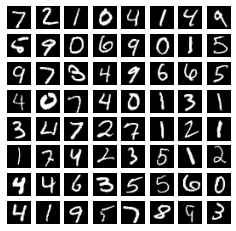

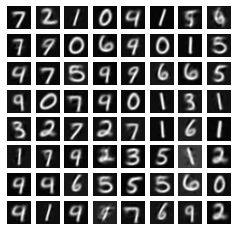

In [34]:
x  = Variable(torch.from_numpy(test_x))
model.eval()
o  = model(x)
z  = model.z()

o  = o.detach().numpy()
plotImages(test_x[:64])
plotImages(o[:64])

### Plot distribution in 2-D latent space

In [29]:
def normalize(x):
    mean = x.mean()
    std  = x.std()
    return (x - mean)/std

In [32]:
def plotResults(x, y, t, 
                xmin=-2.0, xmax= 2.0, 
                ymin=-2.0, ymax= 2.0,
                ftsize=FONTSIZE):

    #fig = plt.figure()
    #ax  = fig.add_subplot(111, projection='3d')
    #ax.scatter(xs, ys, zs, marker=m)

    #ax.set_xlabel('X Label')
    #ax.set_ylabel('Y Label')
    #ax.set_zlabel('Z Label')

    # set size of figure
    plt.figure(figsize=(5, 5))
    
    # annotate axes
    plt.xlabel('$z_1$', fontsize=ftsize)
    plt.ylabel('$z_2$', fontsize=ftsize)

    xaxis_lim = np.array([xmin, xmax])
    yaxis_lim = np.array([ymin, ymax])

    colors = ['grey', 'lightcoral', 'red', 'darkorange', 
              'gold', 'green', 'blue', 
              'royalblue', 'indigo', 'violet']
    kolors = [colors[i] for i in t]
    plt.scatter(normalize(x), normalize(y), c=kolors, lw=0, s=4)
    plt.xlim(xaxis_lim)
    plt.ylim(yaxis_lim)
    plt.savefig('mnist_autoencoder_results03.pdf')
    
    #fig.tight_layout()
    plt.show()

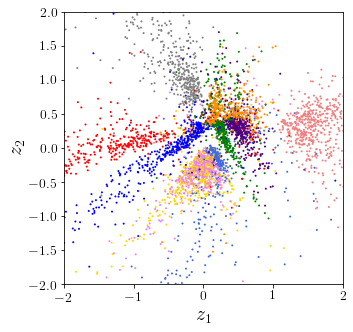

In [35]:
N  = 5000
z1 = z[:,0][:N]
z2 = z[:,1][:N]
y  = test_y[:N]

plotResults(z1, z2, y)